In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
cutoff = 7.068872962487293e-06

In [3]:
data = pd.read_csv("/Users/HaoWoo/Desktop/Bio_Research/training_data.csv")
data["output"] = 0
data.loc[data["sqr_diff"]>=cutoff,"output"] = 1
print (data) 

                  pred  neighbor_min  neighbor_med  neighbor_max  \
0         1.000000e+00  3.448735e-01      0.999999      1.000000   
1         2.303483e-01  1.373577e-02      0.356021      1.000000   
2         1.214818e-02  5.842320e-03      0.022058      0.806485   
3         7.544638e-03  5.842320e-03      0.010829      0.024479   
4         9.081059e-03  8.041023e-03      0.011586      0.017962   
...                ...           ...           ...           ...   
23585333  1.923477e-03  2.356266e-07      0.000063      1.000000   
23585334  8.860329e-07  2.356266e-07      0.000010      0.949198   
23585335  1.000000e+00  9.134875e-06      0.974640      1.000000   
23585336  1.729165e-04  1.150460e-06      0.001329      1.000000   
23585337  1.000000e+00  1.915087e-03      0.999998      1.000000   

          neighbor_mean  neighbor_sd      sqr_diff  output  
0              0.887225     0.217816  6.646194e-16       0  
1              0.502149     0.419060  5.923637e-01       1  


In [4]:
data_samples = data.shape[0]

X_train = (data.iloc[0:int(data_samples*85/100),0:6]).to_numpy().T
Y_train = (data.iloc[0:int(data_samples*85/100),7]).to_numpy().reshape([int(data_samples*85/100),1]).T

X_test = (data.iloc[int(data_samples*85/100):,0:6]).to_numpy().T
Y_test = (data.iloc[int(data_samples*85/100):,7]).to_numpy().reshape([data_samples-int(data_samples*85/100),1]).T

print (X_train.shape) #(6, 20047537)
print (Y_train.shape) #(1, 20047537)
print (X_test.shape) #(6, 3537801)
print (Y_test.shape) #(6, 3537801)

(6, 20047537)
(1, 20047537)
(6, 3537801)
(1, 3537801)


## Helper Functions
Activating Function - Sigmoid

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))

    return s

In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [7]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of size (6, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1] # number of examples
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost = (-np.dot(Y,(np.log(A)).T)-np.dot(1-Y, (np.log(1-A)).T))/m                                 # compute cost

    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, (A-Y).T)/m
    db = np.sum(A-Y)/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of shape (6, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in tqdm(range(num_iterations)):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [9]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of size (6, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in tqdm(range(A.shape[1])):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Model

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 500, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function implemented above
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (6, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (6, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(np.shape(X_train)[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = True)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [11]:
d = model(X_train, Y_train, X_test, Y_test, num_iterations = 1500, learning_rate = 0.5, print_cost = False)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.535369
Cost after iteration 200: 0.530648
Cost after iteration 300: 0.528553
Cost after iteration 400: 0.527239
Cost after iteration 500: 0.526256
Cost after iteration 600: 0.525440
Cost after iteration 700: 0.524725
Cost after iteration 800: 0.524083
Cost after iteration 900: 0.523499
Cost after iteration 1000: 0.522964
Cost after iteration 1100: 0.522473
Cost after iteration 1200: 0.522019
Cost after iteration 1300: 0.521600
Cost after iteration 1400: 0.521211




train accuracy: 75.21038120543187 %
test accuracy: 75.88555715824604 %


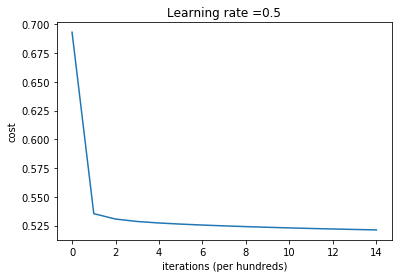

In [12]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.25


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.542991
Cost after iteration 200: 0.535388
Cost after iteration 300: 0.532389
Cost after iteration 400: 0.530653
Cost after iteration 500: 0.529456
Cost after iteration 600: 0.528556
Cost after iteration 700: 0.527839
Cost after iteration 800: 0.527240
Cost after iteration 900: 0.526721
Cost after iteration 1000: 0.526257
Cost after iteration 1100: 0.525833
Cost after iteration 1200: 0.525441
Cost after iteration 1300: 0.525073
Cost after iteration 1400: 0.524726




train accuracy: 75.0154994102268 %
test accuracy: 75.69057728232877 %

-------------------------------------------------------

learning rate is: 0.1


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.556797
Cost after iteration 200: 0.546095
Cost after iteration 300: 0.540692
Cost after iteration 400: 0.537476
Cost after iteration 500: 0.535400
Cost after iteration 600: 0.533945
Cost after iteration 700: 0.532851
Cost after iteration 800: 0.531982
Cost after iteration 900: 0.531265
Cost after iteration 1000: 0.530656
Cost after iteration 1100: 0.530130
Cost after iteration 1200: 0.529669
Cost after iteration 1300: 0.529259
Cost after iteration 1400: 0.528891




train accuracy: 75.21071541107518 %
test accuracy: 75.89663748752403 %

-------------------------------------------------------

learning rate is: 0.05


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.573938
Cost after iteration 200: 0.556839
Cost after iteration 300: 0.550306
Cost after iteration 400: 0.546107
Cost after iteration 500: 0.543031
Cost after iteration 600: 0.540701
Cost after iteration 700: 0.538900
Cost after iteration 800: 0.537482
Cost after iteration 900: 0.536341
Cost after iteration 1000: 0.535404
Cost after iteration 1100: 0.534618
Cost after iteration 1200: 0.533948
Cost after iteration 1300: 0.533366
Cost after iteration 1400: 0.532853




train accuracy: 75.6612794878493 %
test accuracy: 76.38637673515271 %

-------------------------------------------------------



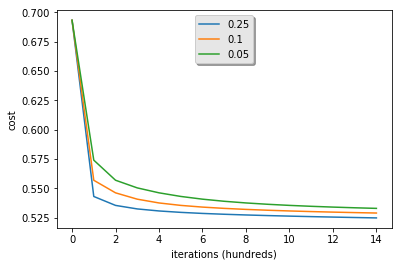

In [13]:
# tuning learning rate
learning_rates = [0.25, 0.1, 0.05]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(X_train, Y_train, X_test, Y_test, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()